In [2]:
import pandas as pd

# TripAdvisor otel yorumları veri setini yükleyelim
df = pd.read_csv("hotelReviews.csv")
print("Toplam yorum sayısı:", len(df))

from sklearn.utils import resample
# Sınıf sayılarının dengelenmesi
upsample_targets = [1, 2, 3]
target_count = 12000  # her azınlık sınıf için hedef örnek sayısı

# Sınıfa göre ayrı ayrı dataframe'leri topla
balanced_df = pd.DataFrame()

for star in sorted(df['rating'].unique()):
    subset = df[df['rating'] == star]

    if star in upsample_targets and len(subset) < target_count:
        upsampled = resample(subset,
                             replace=True,
                             n_samples=target_count,
                             random_state=42)
        balanced_df = pd.concat([balanced_df, upsampled])
    else:
        balanced_df = pd.concat([balanced_df, subset])

# Yeni dağılımı görelim
print("New Star Distribution")
print(balanced_df['rating'].value_counts().sort_index())

# df'yi bu veriyle değiştir
df = balanced_df.reset_index(drop=True)

# Veri yapısını görmek için ilk birkaç satırı gösterelim
df.head(5)

Toplam yorum sayısı: 68785
New Star Distribution
rating
1    12000
2    12000
3    12000
4    13298
5    42809
Name: count, dtype: int64


,hotel_url,profile_reviewer,rating,review_title,review_text,date
0,/Hotel_Review-g293974-d1987604-Reviews-Han_Hot...,/Profile/toofiasal,1,So bad experience,I came from airport to Han hotel I was so tire...,Apr 2017
1,/Hotel_Review-g293974-d3336356-Reviews-or10-Sy...,/Profile/474manale,1,Very bad experience,"Very old hotel need renovation, i made my book...",Mar 2016
2,/Hotel_Review-g293974-d7396356-Reviews-or10-Ra...,/Profile/Extraordinary659768,1,Service is so bad,As a guest as soon as i arrived the hotel exit...,Feb 2019
3,/Hotel_Review-g293974-d7898972-Reviews-Dosso_D...,/Profile/AlexiK29,1,Bad experience,"A very bad hotel in terms of location, very na...",Aug 2023
4,/Hotel_Review-g293974-d3692562-Reviews-Agora_B...,/Profile/MarcusHolmgren,1,STAY AWAY! Shameful treatment by both hotel an...,STAY AWAY FROM THIS HOTEL!!! We got to the hot...,Jul 2018


<ipython-input-3-2408115500>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="rating", ax=axes[0], palette="Blues_r")


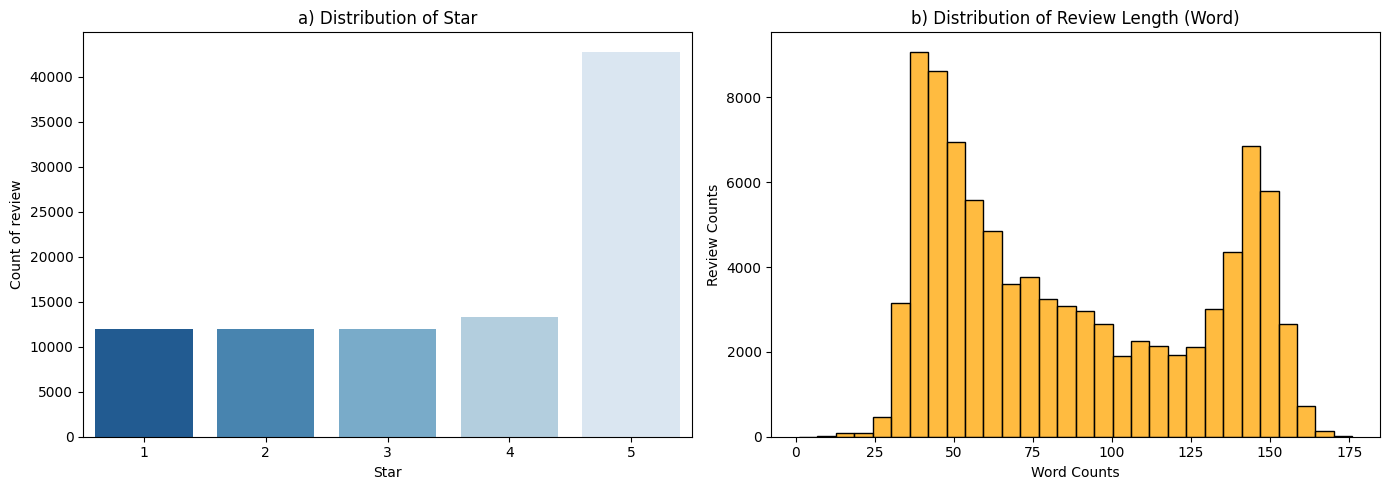

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Yorum uzunluklarını hesapla
df["review_length"] = df["review_text"].apply(lambda x: len(str(x).split()))

# 1. madde: Yıldız puanı ve yorum uzunluğu dağılımları
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# a) Yıldız puanı dağılımı
sns.countplot(data=df, x="rating", ax=axes[0], palette="Blues_r")
axes[0].set_title("a) Distribution of Star")
axes[0].set_xlabel("Star")
axes[0].set_ylabel("Count of review")

# b) Yorum uzunluğu dağılımı
sns.histplot(df["review_length"], bins=30, kde=False, ax=axes[1], color="orange")
axes[1].set_title("b) Distribution of Review Length (Word)")
axes[1].set_xlabel("Word Counts")
axes[1].set_ylabel("Review Counts")

plt.tight_layout()
#plt.suptitle("Graph 1: Star and Distribution of Review Length", fontsize=14, y=1.05)
plt.show()

In [4]:
# Her bir yorumun kelime sayısını hesaplayalım
review_lengths = df['review_text'].astype(str).apply(lambda x: len(x.split()))

# Yorum uzunluklarına dair özet istatistikler (ortalama, medyan, yüzde 95, 99)
print(review_lengths.describe(percentiles=[0.5, 0.95, 0.99]))

count    92107.000000
mean        86.728490
std         41.242764
min          1.000000
50%         76.000000
95%        151.000000
99%        158.000000
max        176.000000
Name: review_text, dtype: float64


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
import re
from collections import Counter

# Tüm yorumları tek bir büyük metin haline getirelim ve küçültelim
all_text = " ".join(df['review_text'].astype(str)).lower()

# Noktalama işaretlerini kaldır (kelime frekansı analizi için)
all_text_clean = re.sub(r"[^\w\s]", " ", all_text)
words = all_text_clean.split()

# Kelime frekanslarını say
freq = Counter(words)
print("10 most frequent word (stopwords included):", freq.most_common(10))

# İngilizce durak kelimelerini çıkarıp tekrar en sık kelimelere bakalım
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words_nostop = [w for w in words if w not in stop_words]
freq_nostop = Counter(words_nostop)
print("10 most frequent word (stopwords excluded):", freq_nostop.most_common(10))

10 most frequent word (stopwords included): [('the', 490790), ('and', 307166), ('to', 206628), ('a', 180152), ('was', 148516), ('is', 145174), ('in', 131507), ('hotel', 129898), ('i', 124210), ('of', 107503)]
10 most frequent word (stopwords excluded): [('hotel', 129898), ('room', 77832), ('staff', 52845), ('good', 47497), ('breakfast', 44180), ('rooms', 36937), ('location', 36579), ('clean', 34052), ('stay', 33677), ('istanbul', 29725)]


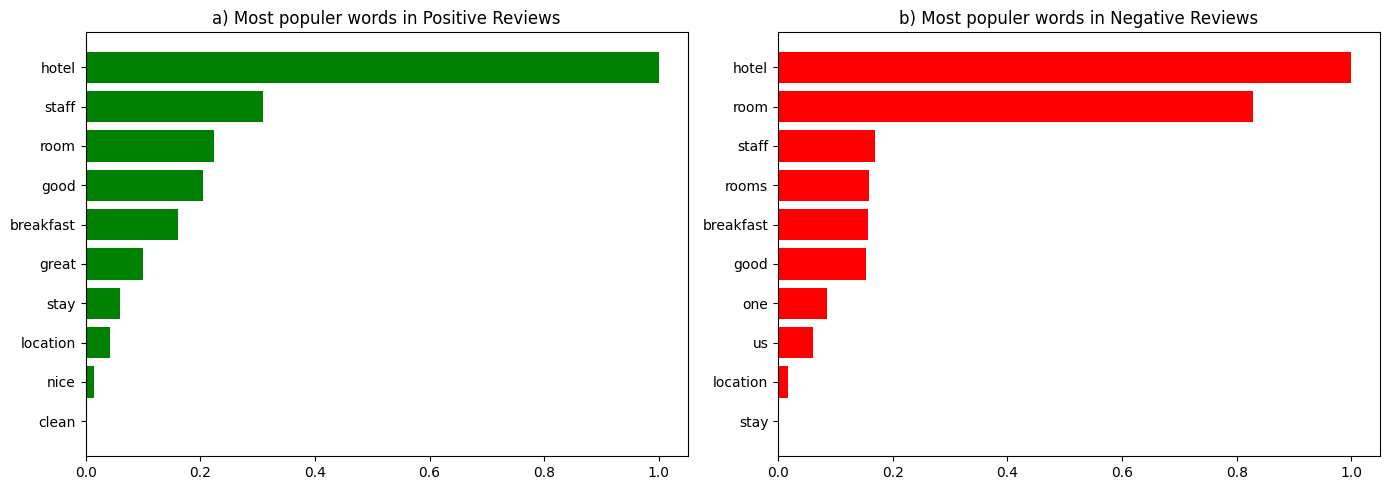

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def preprocess_text(text):
    tokens = str(text).lower().split()
    filtered = [word for word in tokens if word not in stop_words and word.isalpha()]
    return " ".join(filtered)

df["clean_text"] = df["review_text"].apply(preprocess_text)

# Pozitif ve negatif yorumları ayır
positive_reviews = df[df["rating"] >= 4]["clean_text"]
negative_reviews = df[df["rating"] <= 3]["clean_text"]

# CountVectorizer ile en sık geçen 10 kelime
def get_top_words(text_series, top_n=10):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text_series)
    total_counts = X.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    word_freq = dict(zip(vocab, total_counts))
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Normalize et (0-1 arası)
    words, freqs = zip(*sorted_words)
    scaler = MinMaxScaler()
    normalized_freqs = scaler.fit_transform(np.array(freqs).reshape(-1, 1)).flatten()

    return list(words), normalized_freqs

pos_words, pos_freqs = get_top_words(positive_reviews)
neg_words, neg_freqs = get_top_words(negative_reviews)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pozitif
axes[0].barh(pos_words, pos_freqs, color='green')
axes[0].set_title("a) Most populer words in Positive Reviews")
axes[0].invert_yaxis()

# Negatif
axes[1].barh(neg_words, neg_freqs, color='red')
axes[1].set_title("b) Most populer words in Negative Reviews")
axes[1].invert_yaxis()

#plt.suptitle("Şekil 2: Pozitif ve Negatif Yorumlarda En Popüler 10 Kelime (Normalize Edilmiş)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

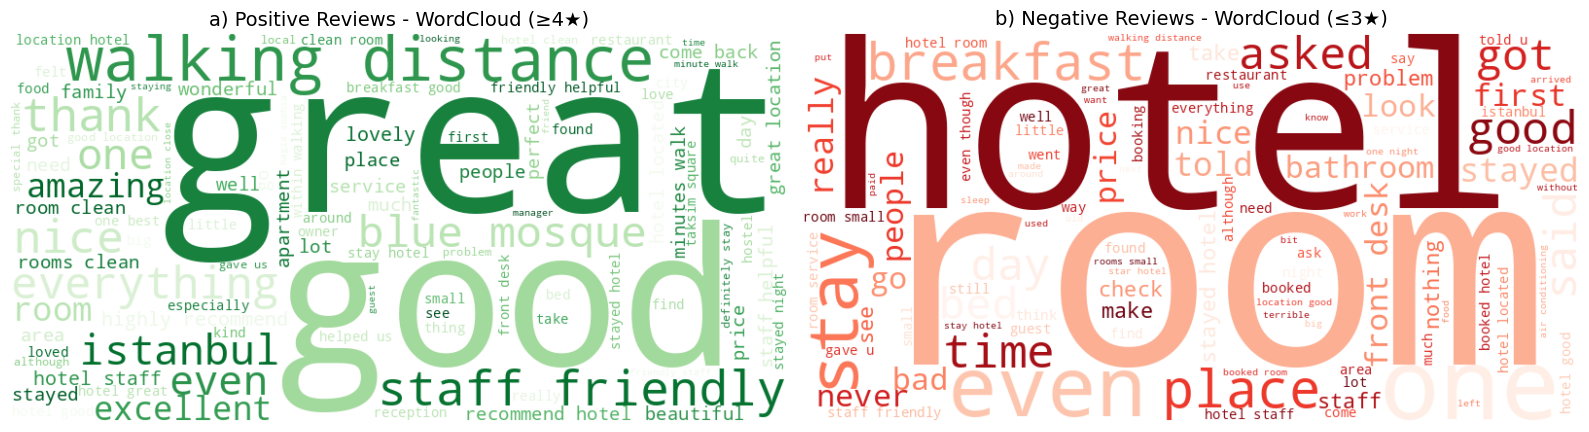

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Pozitif ve negatif yorumları al
positive_text = " ".join(df[df['rating'] >= 4]["clean_text"])
negative_text = " ".join(df[df['rating'] <= 3]["clean_text"])

# Ortak stopwords (zaten temizleme yaptıysan bu adım ekstra koruma sağlar)
stopwords = set(STOPWORDS)

# WordCloud nesneleri
positive_wc = WordCloud(width=800, height=400, background_color="white", colormap="Greens",
                        stopwords=stopwords, max_words=100).generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color="white", colormap="Reds",
                        stopwords=stopwords, max_words=100).generate(negative_text)

# Subgraph ile çizim
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# a) Pozitif WordCloud
axes[0].imshow(positive_wc, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("a) Positive Reviews - WordCloud (≥4★)", fontsize=14)

# b) Negatif WordCloud
axes[1].imshow(negative_wc, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("b) Negative Reviews - WordCloud (≤3★)", fontsize=14)

#plt.suptitle("Şekil 4: Pozitif ve Negatif Yorumlar için WordCloud Görselleştirmesi", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

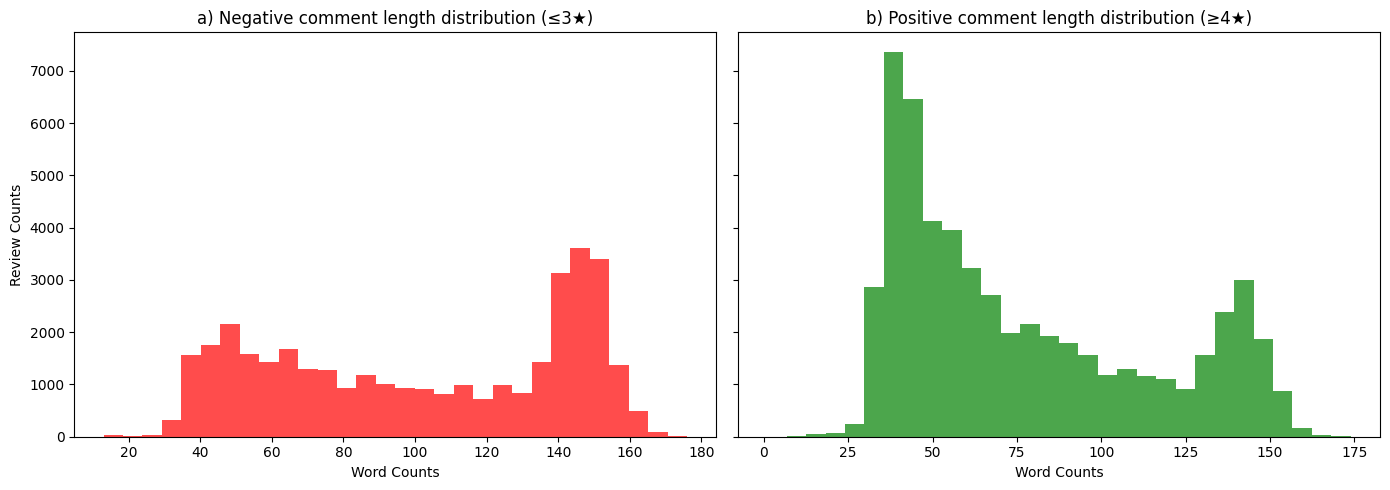

In [9]:
import matplotlib.pyplot as plt

# Yorum uzunluklarını hesapla
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Gruplar
positive_lengths = df[df['rating'] >= 4]['review_length']
negative_lengths = df[df['rating'] <= 3]['review_length']

# Subgraph oluştur
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# a) Negatif yorumlar
axes[0].hist(negative_lengths, bins=30, color='red', alpha=0.7)
axes[0].set_title("a) Negative comment length distribution (≤3★)")
axes[0].set_xlabel("Word Counts")
axes[0].set_ylabel("Review Counts")

# b) Pozitif yorumlar
axes[1].hist(positive_lengths, bins=30, color='green', alpha=0.7)
axes[1].set_title("b) Positive comment length distribution (≥4★)")
axes[1].set_xlabel("Word Counts")

# Genel başlık
#plt.suptitle("Şekil 3: Yorum Uzunluğu Dağılımı - Pozitif ve Negatif", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

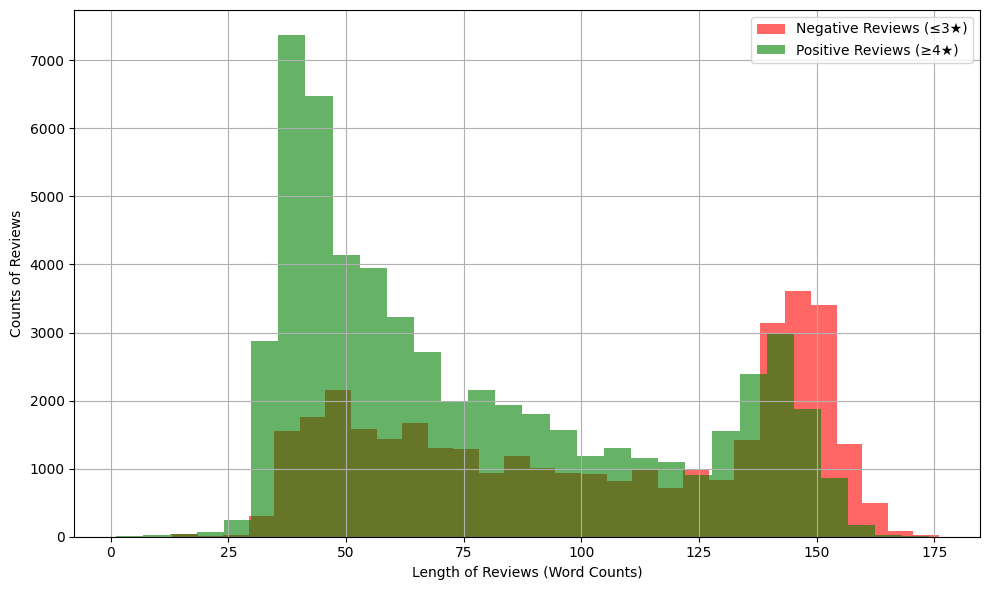

In [10]:
import matplotlib.pyplot as plt

# Yorum uzunluklarını hesapla (kelime bazında)
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Pozitif ve negatif yorumlar
positive_lengths = df[df['rating'] >= 4]['review_length']
negative_lengths = df[df['rating'] <= 3]['review_length']

# Histogram (dağılım) çizimi
plt.figure(figsize=(10, 6))
plt.hist(negative_lengths, bins=30, alpha=0.6, color='red', label='Negative Reviews (≤3★)')
plt.hist(positive_lengths, bins=30, alpha=0.6, color='green', label='Positive Reviews (≥4★)')
#plt.title("Şekil 3: Yorum Uzunluğu Dağılımı - Pozitif vs Negatif")
plt.xlabel("Length of Reviews (Word Counts)")
plt.ylabel("Counts of Reviews")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Küçük harfe çevir
    text = text.lower()
    # Noktalama işaretlerini kaldır
    text = re.sub(r"[^\w\s]", " ", text)
    # Kelimelere böl
    tokens = nltk.word_tokenize(text)
    # Durak kelimeleri çıkar ve kelimeleri köklerine (lemma) indirgeme
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    # Tekrar metne birleştir
    return " ".join(tokens)

# Örnek kullanım:
sample_review = df['review_text'].iloc[0]
print("Original:", sample_review)
print("After preprocessing:", preprocess_text(sample_review))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Original: I came from airport to Han hotel I was so tired they ask me to pay 75$ which is 270 lt per night , for nothing the roof wasn't colored!!! in the room no coffee smell bad from panting , I check for the price in online it's just 30$ per night In same day!!!  I know the online is cheaper but there's some thing wrong so be careful 
After preprocessing: came airport han hotel tired ask pay 75 270 lt per night nothing roof colored room coffee smell bad panting check price online 30 per night day know online cheaper thing wrong careful


In [12]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# (Opsiyonel) Hızlı deneme amaçlı veri setini bir alt kümeye indirmek:
# df = df.sample(20000, random_state=42)

# Tabakalı şekilde eğitim (%80) ve test (%20) olarak ayır
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['rating'])
print("Training data count:", len(train_df), "Test data count:", len(test_df))

# Model için etiketleri 0-4 aralığına çek (1★->0, 2★->1, ..., 5★->4)
train_df['label'] = train_df['rating'] - 1
test_df['label'] = test_df['rating'] - 1

# HuggingFace Dataset formatına dönüştür (sadece review_text ve label alanlarıyla)
train_dataset = Dataset.from_pandas(train_df[['review_text','label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['review_text','label']].reset_index(drop=True))

Training data count: 73685 Test data count: 18422



DistilBERT model training...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/73685 [00:00<?, ? examples/s]

Map:   0%|          | 0/18422 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.572000,0.545763,0.780968,0.740868,0.781675,0.988630
2,0.364700,0.446231,0.839051,0.810659,0.831233,0.992460


DistilBERT Training 1746.32 took seconds


DistilBERT evaluation metrics: {'eval_loss': 0.44623133540153503, 'eval_accuracy': 0.8390511345130822, 'eval_f1_macro': 0.8106586074419067, 'eval_f1_weighted': 0.8312333768225817, 'eval_roc_auc': 0.9924603890671102, 'eval_runtime': 67.3083, 'eval_samples_per_second': 273.696, 'eval_steps_per_second': 17.115, 'epoch': 2.0}
DistilBERT confusion matrix:
 [[2215  148   22    0   15]
 [  41 2312   40    4    3]
 [  29  144 1986  186   55]
 [  11   24  301 1112 1212]
 [  10   11   60  649 7832]]

BERT model training...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/73685 [00:00<?, ? examples/s]

Map:   0%|          | 0/18422 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.627300,0.599542,0.761861,0.713722,0.760680,0.985978


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.627300,0.599542,0.761861,0.713722,0.760680,0.985978
2,0.426900,0.488103,0.821952,0.783622,0.813096,0.990465


BERT Training 3479.17 took seconds


BERT evaluation metrics: {'eval_loss': 0.4881027042865753, 'eval_accuracy': 0.8219520138964281, 'eval_f1_macro': 0.7836221833890793, 'eval_f1_weighted': 0.8130963921827102, 'eval_roc_auc': 0.9904647121725184, 'eval_runtime': 132.9155, 'eval_samples_per_second': 138.599, 'eval_steps_per_second': 8.667, 'epoch': 2.0}
BERT confusion matrix:
 [[2161  203   18    0   18]
 [ 125 2218   52    2    3]
 [  30  198 1886  229   57]
 [  16   28  353 1039 1224]
 [  10   11   79  624 7838]]

RoBERTa model training...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/73685 [00:00<?, ? examples/s]

Map:   0%|          | 0/18422 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.613400,0.589158,0.766366,0.714970,0.765517,0.987110
2,0.429200,0.466837,0.830692,0.794358,0.822519,0.990848


RoBERTa Training 3525.21 took seconds


RoBERTa evaluation metrics: {'eval_loss': 0.46683695912361145, 'eval_accuracy': 0.8306915644338291, 'eval_f1_macro': 0.7943583407481254, 'eval_f1_weighted': 0.8225191037868947, 'eval_roc_auc': 0.9908477024297512, 'eval_runtime': 128.556, 'eval_samples_per_second': 143.299, 'eval_steps_per_second': 8.961, 'epoch': 2.0}
RoBERTa confusion matrix:
 [[2153  215   12    0   20]
 [  87 2247   59    2    5]
 [  34  201 1884  224   57]
 [   9   29  324 1111 1187]
 [   8    9   54  583 7908]]

DeBERTa model training...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Map:   0%|          | 0/73685 [00:00<?, ? examples/s]

Map:   0%|          | 0/18422 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Roc Auc
1,0.565400,0.542688,0.788242,0.746107,0.786585,0.988971
2,0.354200,0.434569,0.843828,0.814092,0.836082,0.992844


DeBERTa Training 4456.96 took seconds


DeBERTa evaluation metrics: {'eval_loss': 0.43456941843032837, 'eval_accuracy': 0.8438280317012268, 'eval_f1_macro': 0.8140918816715471, 'eval_f1_weighted': 0.8360818840804705, 'eval_roc_auc': 0.992843991960237, 'eval_runtime': 171.8976, 'eval_samples_per_second': 107.168, 'eval_steps_per_second': 6.702, 'epoch': 2.0}
DeBERTa confusion matrix:
 [[2216  149   18    1   16]
 [  55 2291   49    2    3]
 [  29  145 1983  200   43]
 [  11   19  307 1144 1179]
 [   4    6   49  592 7911]]


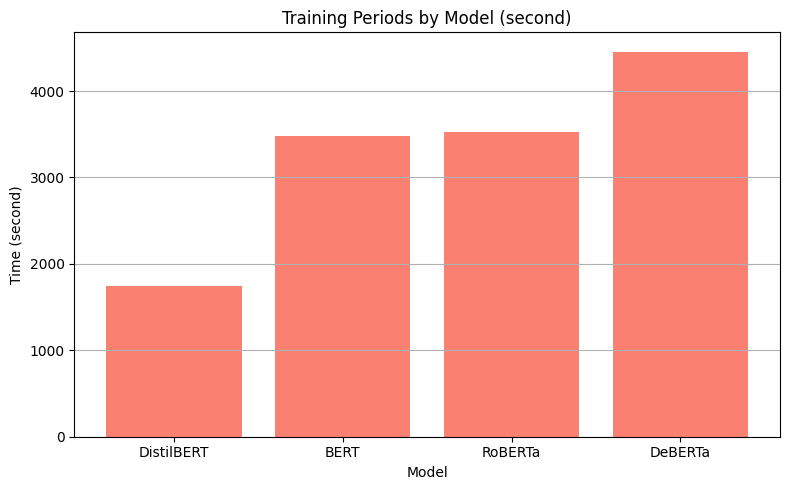

In [13]:
import numpy as np
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from datasets import Dataset

training_durations = {}  # Eğitim sürelerini burada tutacağız

def train_and_evaluate(model_name: str, model_checkpoint: str, train_data: Dataset, test_data: Dataset, epochs: int = 2, batch_size: int = 16):
    print(f"\n{model_name} model training...")

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=5)

    def tokenize_batch(batch):
        return tokenizer(batch['review_text'], truncation=True, padding=True, max_length=128)

    train_enc = train_data.map(tokenize_batch, batched=True)
    test_enc = test_data.map(tokenize_batch, batched=True)

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = np.argmax(pred.predictions, axis=1)
        acc = accuracy_score(labels, preds)
        f1_macro = f1_score(labels, preds, average='macro')
        f1_weighted = f1_score(labels, preds, average='weighted')
        binary_labels = [1 if l >= 3 else 0 for l in labels]
        probs = np.exp(pred.predictions) / np.exp(pred.predictions).sum(axis=1, keepdims=True)
        pos_probs = probs[:, 3] + probs[:, 4]
        try:
            roc = roc_auc_score(binary_labels, pos_probs)
        except ValueError:
            roc = np.nan
        return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted, "roc_auc": roc}

    training_args = TrainingArguments(
        output_dir=f"{model_name}_results",
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=500,
        load_best_model_at_end=False,
        seed=42,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_enc,
        eval_dataset=test_enc,
        compute_metrics=compute_metrics
    )

    # Eğitim süresini ölç
    start_time = time.time()
    trainer.train()
    end_time = time.time()

    training_time = end_time - start_time
    training_durations[model_name] = training_time
    print(f"{model_name} Training {training_time:.2f} took seconds")

    eval_metrics = trainer.evaluate(test_enc)
    preds = np.argmax(trainer.predict(test_enc).predictions, axis=1)
    cm = confusion_matrix(test_enc['label'], preds)

    print(f"{model_name} evaluation metrics:", eval_metrics)
    print(f"{model_name} confusion matrix:\n", cm)

    return eval_metrics, cm, trainer.model


# Eğitilecek modeller
models = {
    "DistilBERT": "distilbert-base-uncased",
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DeBERTa": "microsoft/deberta-base"
}

results = {}
confusion_matrices = {}
trained_models = {}

for name, checkpoint in models.items():
    metrics, cm, model = train_and_evaluate(name, checkpoint, train_dataset, test_dataset, epochs=2, batch_size=16)
    results[name] = metrics
    confusion_matrices[name] = cm
    trained_models[name] = model

# Eğitim sürelerini bar chart ile çiz
plt.figure(figsize=(8, 5))
plt.bar(training_durations.keys(), training_durations.values(), color='salmon')
plt.title("Training Periods by Model (second)")
plt.ylabel("Time (second)")
plt.xlabel("Model")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [14]:
# Eğitilen her modelin metriklerini yazdıralım
for name, metrics in results.items():
    acc = metrics['eval_accuracy']
    f1 = metrics['eval_f1_macro']
    roc = metrics['eval_roc_auc']
    print(f"{name}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}, ROC-AUC={roc:.3f}")

DistilBERT: Accuracy=0.839, Macro-F1=0.811, ROC-AUC=0.992
BERT: Accuracy=0.822, Macro-F1=0.784, ROC-AUC=0.990
RoBERTa: Accuracy=0.831, Macro-F1=0.794, ROC-AUC=0.991
DeBERTa: Accuracy=0.844, Macro-F1=0.814, ROC-AUC=0.993


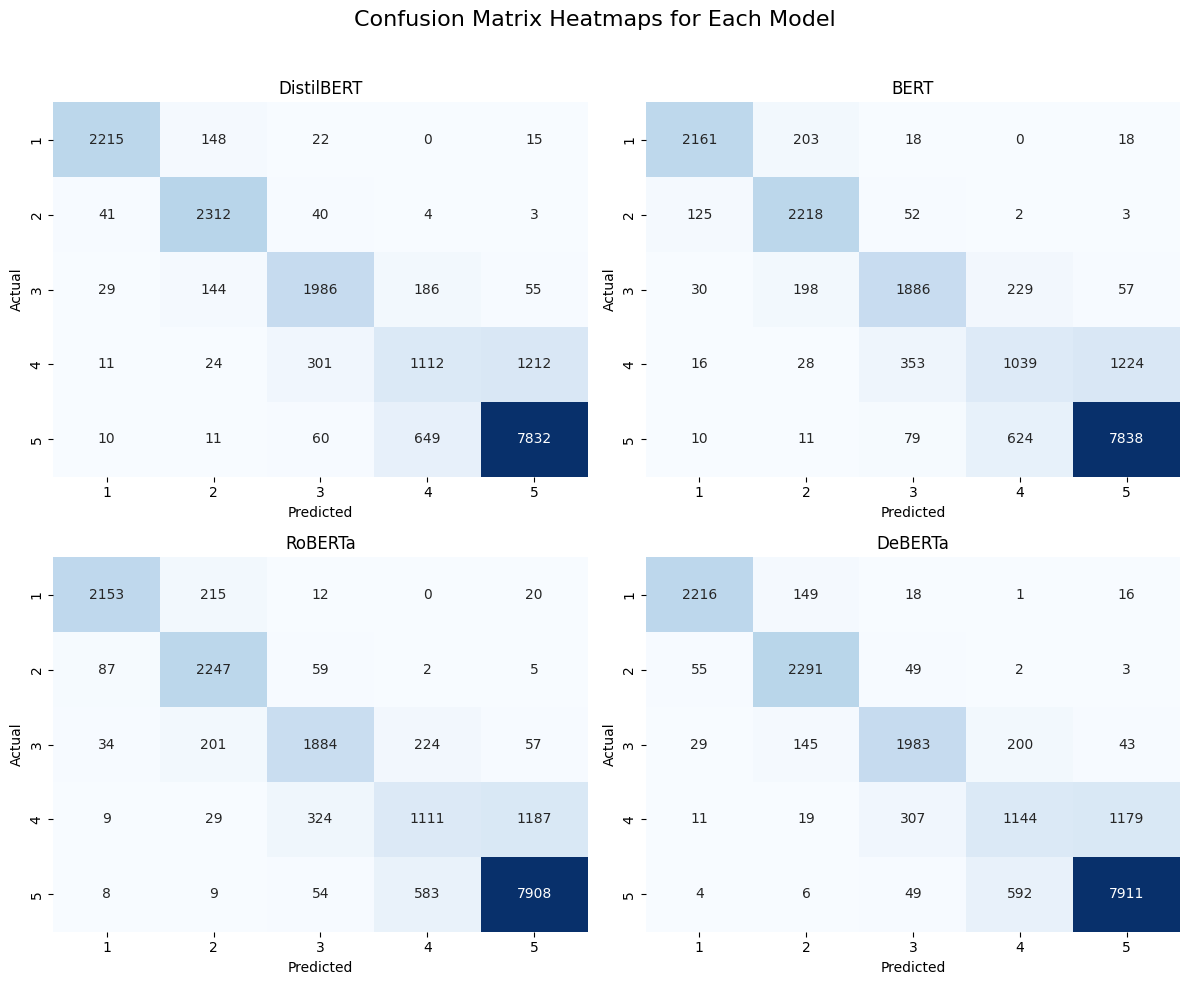

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix görselleştirmesi
model_names = ["DistilBERT", "BERT", "RoBERTa", "DeBERTa"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Confusion Matrix Heatmaps for Each Model", fontsize=16)

# 1-5 yıldız etiketleri
star_labels = [1, 2, 3, 4, 5]

for ax, name in zip(axes.flat, model_names):
    cm = confusion_matrices[name]
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=ax,
        cbar=False,
        xticklabels=star_labels,
        yticklabels=star_labels
    )
    ax.set_title(f"{name}", fontsize=12)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Başlıkla çakışmasın
plt.show()


100%|██████████| 300/300 [00:08<00:00, 36.38it/s]


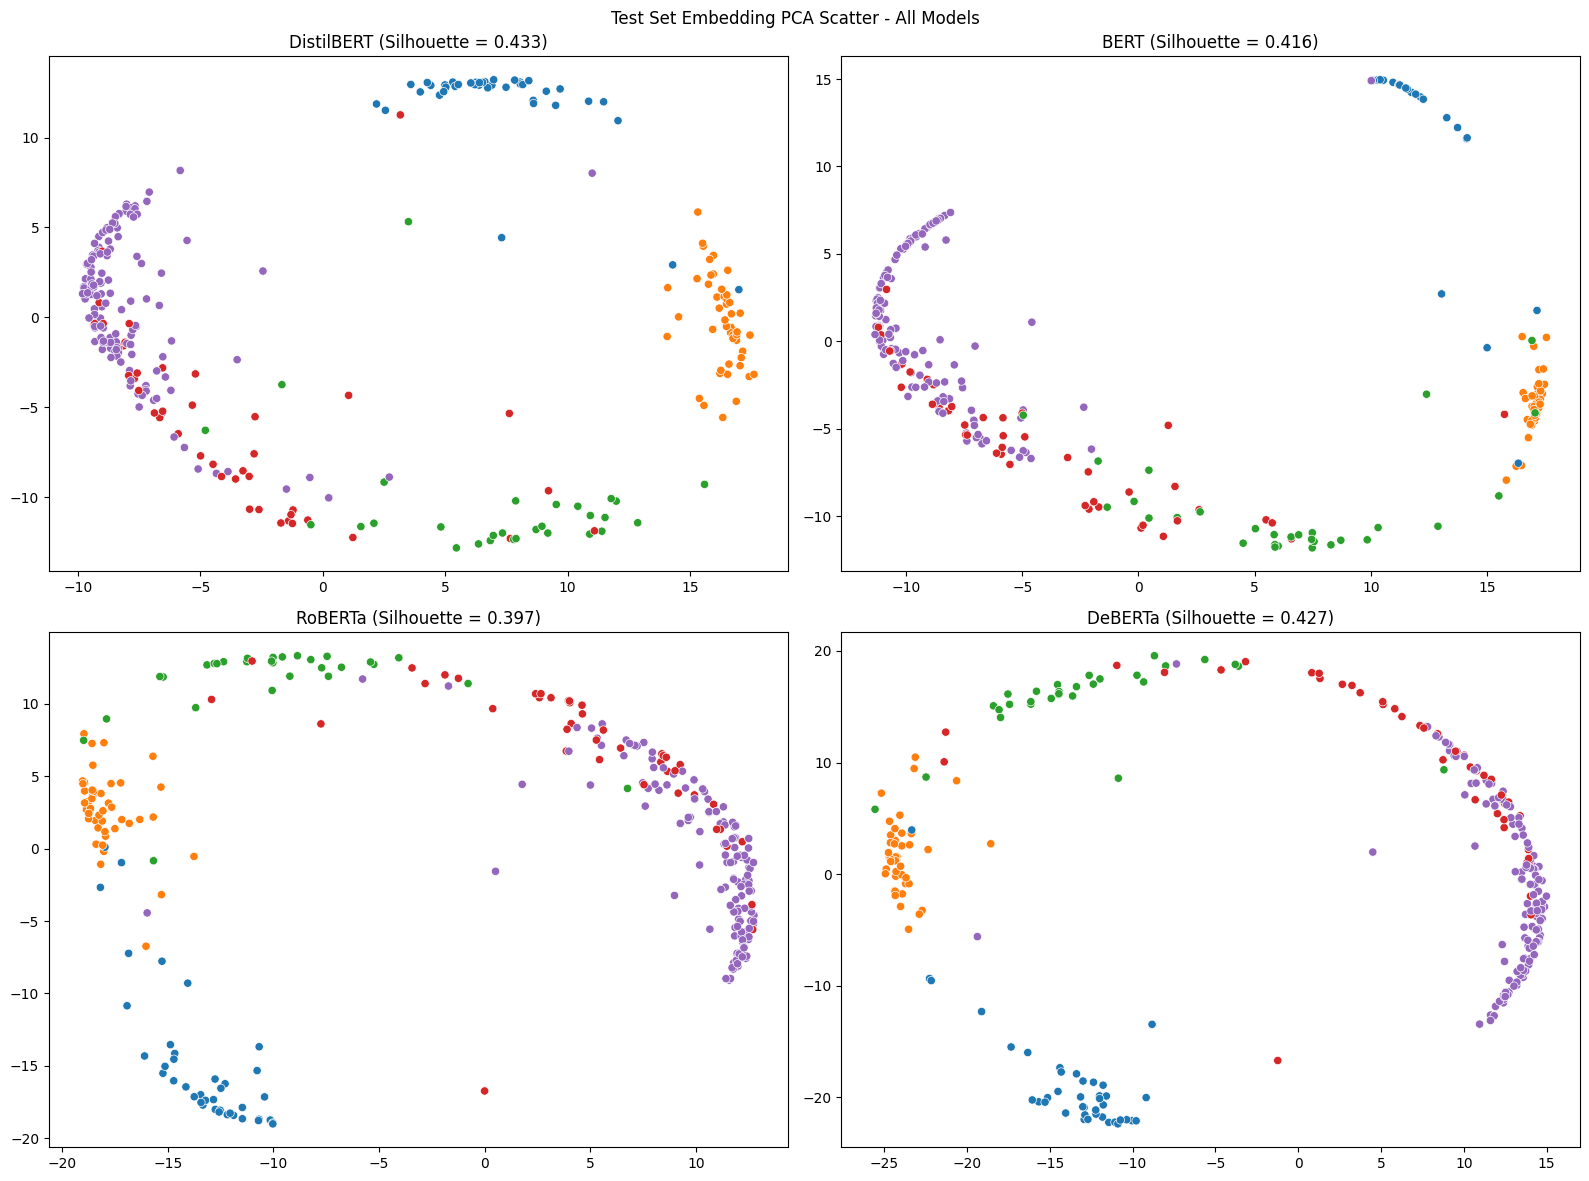


Silhouette Scores:
DistilBERT: 0.433
BERT: 0.416
RoBERTa: 0.397
DeBERTa: 0.427


In [16]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

from tqdm import tqdm

def extract_embeddings(model, tokenizer, texts):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for text in tqdm(texts):
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            outputs = model(**inputs, output_hidden_states=True, return_dict=True)
            hidden_states = outputs.hidden_states[-1]  # last layer
            cls_embedding = hidden_states[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(cls_embedding)
    return np.vstack(embeddings)

# Örnekleme yapalım (tüm test seti yerine 300 yorum seçelim)
sample_df = test_df.sample(300, random_state=42).reset_index(drop=True)
sample_texts = sample_df['review_text'].tolist()
sample_labels = sample_df['rating'].values

# Tüm modeller için embed ve PCA
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

silhouette_scores = {}

for i, (name, model) in enumerate(trained_models.items()):
    tokenizer = AutoTokenizer.from_pretrained(models[name], use_fast=False)
    embeds = extract_embeddings(model, tokenizer, sample_texts)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeds)
    sil_score = silhouette_score(reduced, sample_labels)
    silhouette_scores[name] = sil_score

    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=sample_labels, palette='tab10', ax=axes[i], legend=False)
    axes[i].set_title(f"{name} (Silhouette = {sil_score:.3f})")

plt.suptitle("Test Set Embedding PCA Scatter - All Models")
plt.tight_layout()
plt.show()

# Sonuçları yazdıralım
print("\nSilhouette Scores:")
for name, score in silhouette_scores.items():
    print(f"{name}: {score:.3f}")